# PredictionEnsemble Objects

One of the major features of `climpred` is our objects that are based upon the `PredictionEnsemble` class. We supply users with a `HindcastEnsemble` and `PerfectModelEnsemble` object. We encourage users to take advantage of these high-level objects, which wrap all of our core functions. These objects don't comprehensively cover all functions yet, but eventually we'll deprecate direct access to the function calls in favor of the lightweight objects.

Briefly, we consider a `HindcastEnsemble` to be one that is initialized from some observational-like product (e.g., assimilated data, reanalysis products, or a model reconstruction). Thus, this object is built around comparing the initialized ensemble to various observational products. In contrast, a `PerfectModelEnsemble` is one that is initialized off of a model control simulation. These forecasting systems are not meant to be compared directly to real-world observations. Instead, they provide a contained model environment with which to theoretically study the limits of predictability. You can read more about the terminology used in `climpred` [here](terminology.html).

Let's create a demo object to explore some of the functionality and why they are much smoother to use than direct function calls.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr

from climpred import HindcastEnsemble
import climpred

We can pull in some sample data that is packaged with `climpred`.

In [2]:
climpred.tutorial.load_dataset()

'MPI-control-1D': area averages for the MPI control run of SST/SSS.
'MPI-control-3D': lat/lon/time for the MPI control run of SST/SSS.
'MPI-PM-DP-1D': perfect model decadal prediction ensemble area averages of SST/SSS/AMO.
'MPI-PM-DP-3D': perfect model decadal prediction ensemble lat/lon/time of SST/SSS/AMO.
'CESM-DP-SST': hindcast decadal prediction ensemble of global mean SSTs.
'CESM-DP-SSS': hindcast decadal prediction ensemble of global mean SSS.
'CESM-DP-SST-3D': hindcast decadal prediction ensemble of eastern Pacific SSTs.
'CESM-LE': uninitialized ensemble of global mean SSTs.
'MPIESM_miklip_baseline1-hind-SST-global': hindcast initialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-hist-SST-global': uninitialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-assim-SST-global': assimilation in MPI-ESM of global mean SSTs
'ERSST': observations of global mean SSTs.
'FOSI-SST': reconstruction of global mean SSTs.
'FOSI-SSS': reconstruction of global mean SSS.
'FOSI

## HindcastEnsemble

We'll start out with a `HindcastEnsemble` demo, followed by a `PerfectModelEnsemble` case.

In [3]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST') # CESM-DPLE hindcast ensemble output.
obs = climpred.tutorial.load_dataset('ERSST') # ERSST observations.
recon = climpred.tutorial.load_dataset('FOSI-SST') # Reconstruction simulation that initialized CESM-DPLE.

We need to add a "units" attribute to the hindcast ensemble so that `climpred` knows how to interpret the lead units.

In [4]:
hind["lead"].attrs["units"] = "years"

CESM-DPLE was drift-corrected prior to uploading the output, so we just need to subtract the climatology over the same period for our other products before building the object.

In [5]:
obs = obs - obs.sel(time=slice(1964, 2014)).mean('time')
recon = recon - recon.sel(time=slice(1964, 2014)).mean('time')

Now we instantiate the `HindcastEnsemble` object and append all of our products to it.

In [6]:
hindcast = HindcastEnsemble(hind) # Instantiate object by passing in our initialized ensemble.
print(hindcast)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, member) float64 ...
Observationss:
    None
Uninitialized:
    None


/Users/ribr5703/miniconda3/envs/climpred-dev/lib/python3.6/site-packages/climpred/utils.py:48: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '


Now we just use the `add_` methods to attach other objects. See the API [here](api.html#add-and-retrieve-datasets). **Note that we strive to make our conventions follow those of `xarray`'s**. For example, we don't allow inplace operations. One has to run `hindcast = hindcast.add_observations(...)` to modify the object upon later calls rather than just `hindcast.add_observations(...)`.

In [7]:
hindcast = hindcast.add_observations(recon, 'reconstruction')
hindcast = hindcast.add_observations(obs, 'ERSST')

In [8]:
print(hindcast)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, member) float64 ...
reconstruction:
    SST      (time) float64 -0.05064 -0.0868 -0.1396 ... 0.3023 0.3718 0.292
ERSST:
    SST      (time) float32 -0.40146065 -0.35238647 ... 0.34601402 0.45021248
Uninitialized:
    None


You can apply most standard `xarray` functions directly to our objects! `climpred` will loop through the objects and apply the function to all applicable `xarray.Datasets` within the object. If you reference a dimension that doesn't exist for the given `xarray.Dataset`, it will ignore it. This is useful, since the initialized ensemble is expected to have dimension `init`, while other products have dimension `time` (see more [here](setting-up-data.html)).

Let's start by taking the ensemble mean of the initialized ensemble so our metric computations don't have to take the extra time on that later. I'm just going to use deterministic metrics here, so we don't need the individual ensemble members. Note that above our initialized ensemble had a `member` dimension, and now it is reduced.

In [9]:
hindcast = hindcast.mean('member')
print(hindcast)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead) float64 -0.2121 -0.1637 -0.1206 ... 0.7286 0.7532
reconstruction:
    SST      (time) float64 -0.05064 -0.0868 -0.1396 ... 0.3023 0.3718 0.292
ERSST:
    SST      (time) float32 -0.40146065 -0.35238647 ... 0.34601402 0.45021248
Uninitialized:
    None


We still have a trend in all of our products, so we could also detrend them as well.

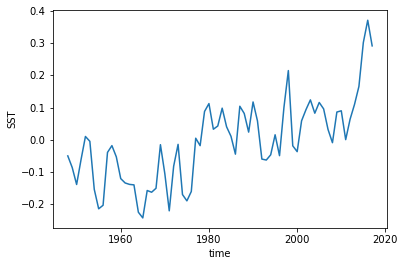

In [10]:
hindcast.get_observations('reconstruction').SST.plot()

In [11]:
from scipy.signal import detrend

I'm going to transpose this first since my initialized ensemble has dimensions ordered `(init, lead)` and `scipy.signal.detrend` is applied over the last axis. I'd like to detrend over the `init` dimension rather than `lead` dimension.

In [12]:
hindcast = hindcast.transpose().apply(detrend)

And it looks like everything got detrended by a linear fit! That wasn't too hard.

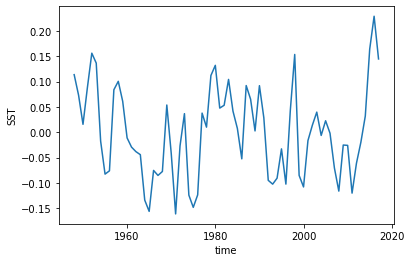

In [13]:
hindcast.get_observations('reconstruction').SST.plot()

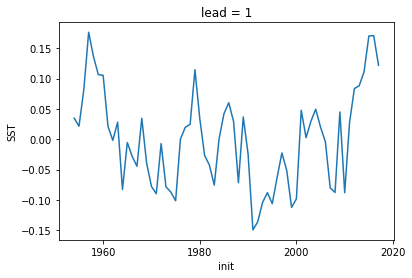

In [14]:
hindcast.get_initialized().isel(lead=0).SST.plot()

Now that we've done our pre-processing, let's quickly compute some metrics. Check the metrics page [here](metrics.html) for all the keywords you can use. The [API](api.html#analysis-functions) is currently pretty simple for the `HindcastEnsemble`. You can essentially compute standard skill metrics and a reference persistence forecast.

If you just pass a metric, it'll compute the skill metric against all observations and return a dictionary with keys of the names the user entered when adding them.

In [15]:
hindcast.verify(metric='mse')

{'reconstruction': <xarray.Dataset>
 Dimensions:  (lead: 10)
 Coordinates:
   * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
 Data variables:
     SST      (lead) float64 0.005091 0.009096 0.008964 ... 0.01103 0.01261
 Attributes:
     prediction_skill:              calculated by climpred https://climpred.re...
     skill_calculated_by_function:  compute_hindcast
     number_of_initializations:     64
     metric:                        mse
     comparison:                    e2o
     dim:                           time
     created:                       2020-01-21 11:46:51,
 'ERSST': <xarray.Dataset>
 Dimensions:  (lead: 10)
 Coordinates:
   * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
 Data variables:
     SST      (lead) float64 0.003606 0.005651 0.006373 ... 0.007823 0.009009
 Attributes:
     prediction_skill:              calculated by climpred https://climpred.re...
     skill_calculated_by_function:  compute_hindcast
     number_of_initializations:     64
     metric:           

One can also directly call individual observations to compare to. Here we leverage `xarray`'s plotting method to compute Mean Absolute Error and the Anomaly Correlation Coefficient for both our observational products, as well as the equivalent metrics computed for persistence forecasts for each of those metrics.

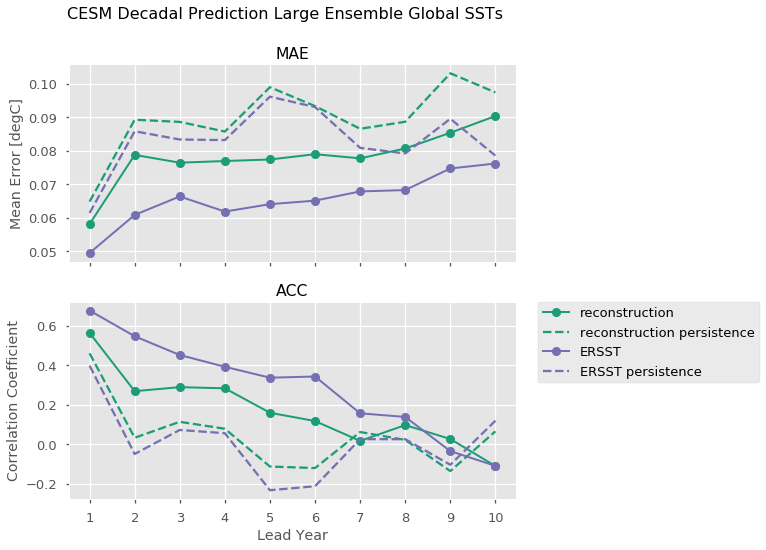

In [16]:
import numpy as np

plt.style.use('ggplot')
plt.style.use('seaborn-talk')

RECON_COLOR = '#1b9e77'
OBS_COLOR = '#7570b3'

f, axs = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)

for ax, metric in zip(axs.ravel(), ['mae', 'acc']):
    handles = []
    for product, color in zip(['reconstruction', 'ERSST'], [RECON_COLOR, OBS_COLOR]):
        p1, = hindcast.verify(product, metric=metric).SST.plot(ax=ax, 
                                                               marker='o', 
                                                               color=color,
                                                               label=product,
                                                               linewidth=2)
        p2, = hindcast.compute_persistence(product, metric=metric).SST.plot(ax=ax, 
                                                                      color=color, 
                                                                      linestyle='--',
                                                                      label=product + ' persistence')
        handles.append(p1)
        handles.append(p2)
    ax.set_title(metric.upper())
    

axs[0].set_ylabel('Mean Error [degC]')
axs[1].set_ylabel('Correlation Coefficient')
axs[0].set_xlabel('')
axs[1].set_xlabel('Lead Year')
axs[1].set_xticks(np.arange(10)+1)

# matplotlib/xarray returning weirdness for the legend handles.
handles = [i.get_label() for i in handles]

# a little trick to put the legend on the outside.
plt.legend(handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.suptitle('CESM Decadal Prediction Large Ensemble Global SSTs', fontsize=16)
plt.show()

## PerfectModelEnsemble

We'll now play around a bit with the `PerfectModelEnsemble` object, using sample data from the MPI perfect model configuration.

In [17]:
from climpred import PerfectModelEnsemble

In [18]:
ds = climpred.tutorial.load_dataset('MPI-PM-DP-1D') # initialized ensemble from MPI
control = climpred.tutorial.load_dataset('MPI-control-1D') # base control run that initialized it

In [19]:
ds["lead"].attrs["units"] = "years"

In [20]:
print(ds)

<xarray.Dataset>
Dimensions:  (area: 3, init: 12, lead: 20, member: 10, period: 5)
Coordinates:
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * period   (period) object 'DJF' 'JJA' 'MAM' 'SON' 'ym'
  * area     (area) object 'global' 'North_Atlantic' 'North_Atlantic_SPG'
  * init     (init) int64 3014 3023 3045 3061 3124 ... 3175 3178 3228 3237 3257
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    tos      (period, lead, area, init, member) float32 ...
    sos      (period, lead, area, init, member) float32 ...
    AMO      (period, lead, area, init, member) float32 ...


In [21]:
pm = climpred.PerfectModelEnsemble(ds)
pm = pm.add_control(control)
print(pm)

<climpred.PerfectModelEnsemble>
Initialized Ensemble:
    tos      (period, lead, area, init, member) float32 ...
    sos      (period, lead, area, init, member) float32 ...
    AMO      (period, lead, area, init, member) float32 ...
Control:
    tos      (period, time, area) float32 ...
    sos      (period, time, area) float32 ...
    AMO      (period, time, area) float32 ...
Uninitialized:
    None


/Users/ribr5703/miniconda3/envs/climpred-dev/lib/python3.6/site-packages/climpred/utils.py:48: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  'Assuming annual resolution due to numeric inits. '


Our objects are carrying sea surface temperature (`tos`), sea surface salinity (`sos`), and the Atlantic Multidecadal Oscillation index (`AMO`). Say we just want to look at skill metrics for temperature and salinity over the North Atlantic in JJA. We can just call a few easy `xarray` commands to filter down our object.

In [22]:
pm = pm.drop('AMO').sel(area='North_Atlantic', period='JJA')

Now we can easily compute for a host of metrics. Here I just show a number of deterministic skill metrics comparing all individual members to the initialized ensemble mean. See [comparisons](comparisons.html) for more information on the `comparison` keyword.

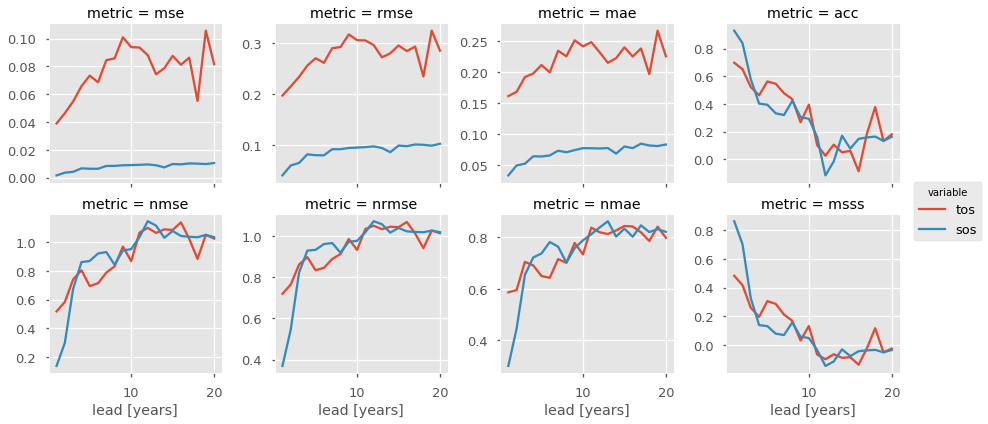

In [23]:
METRICS = ['mse', 'rmse', 'mae', 'acc',
           'nmse', 'nrmse', 'nmae', 'msss']

result = []
for metric in METRICS:
    result.append(pm.compute_metric(metric, comparison='m2e'))
    
result = xr.concat(result, 'metric')
result['metric'] = METRICS

# Leverage the `xarray` plotting wrapper to plot all results at once.
result.to_array().plot(col='metric', 
                       hue='variable', 
                       col_wrap=4, 
                       sharey=False, 
                       sharex=True)

It is useful to compare the initialized ensemble to an uninitialized run. See [terminology](terminology.html) for a description on "uninitialized" simulations. This gives us information about how *initializations* lead to enhanced predictability over knowledge of external forcing, whereas a comparison to persistence just tells us how well a dynamical forecast simulation does in comparison to a naive method. We can use the `generate_uninitialized()` method to bootstrap the control run and create a pseudo-ensemble that approximates what an uninitialized ensemble would look like.

In [24]:
pm = pm.generate_uninitialized()
print(pm)

<climpred.PerfectModelEnsemble>
Initialized Ensemble:
    tos      (lead, init, member) float32 ...
    sos      (lead, init, member) float32 ...
Control:
    tos      (time) float32 ...
    sos      (time) float32 ...
Uninitialized:
    tos      (init, member, lead) float32 13.063092 13.260559 ... 13.264743
    sos      (init, member, lead) float32 33.252388 33.155952 ... 33.101475


In [25]:
pm = pm.drop('tos') # Just assess for salinity.

Here I plot the ACC for the initialized, uninitialized, and persistence forecasts for North Atlantic sea surface salinity in JJA. I add circles to the lines if the correlations are statistically significant for $p <= 0.05$.

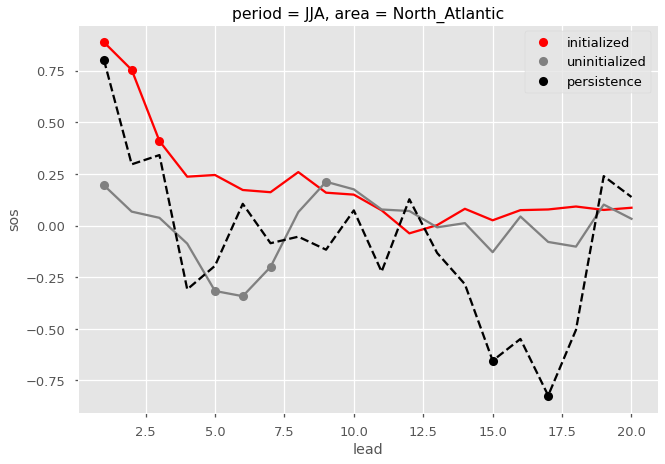

In [26]:
# ACC for initialized ensemble
acc = pm.compute_metric('acc')
acc.sos.plot(color='red')
acc.where(pm.compute_metric('p_pval') <= 0.05).sos.plot(marker='o', linestyle='None', color='red', label='initialized')

# ACC for 'uninitialized' ensemble
acc = pm.compute_uninitialized('acc')
acc.sos.plot(color='gray')
acc.where(pm.compute_uninitialized('p_pval') <= 0.05).sos.plot(marker='o', linestyle='None', color='gray', label='uninitialized')

# ACC for persistence forecast
acc = pm.compute_persistence('acc')
acc.sos.plot(color='k', linestyle='--')
acc.where(pm.compute_persistence('p_pval') <= 0.05).sos.plot(marker='o', linestyle='None', color='k', label='persistence')

plt.legend()